# Capstone - Diabetes Prediction - Modeling

## Setup

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, matthews_corrcoef
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer

**Import Training and Test Data**

In [2]:
# Read in our data
datapath = '../data'
datapath_X_train = os.path.join(datapath, 'X_train.csv')
datapath_X_test = os.path.join(datapath, 'X_test.csv')
datapath_y_train = os.path.join(datapath, 'y_train.csv')
datapath_y_test = os.path.join(datapath, 'y_test.csv')

X_train = pd.read_csv(datapath_X_train)
X_test = pd.read_csv(datapath_X_test)
y_train = pd.read_csv(datapath_y_train)
y_test = pd.read_csv(datapath_y_test)

# Try Different Classifiers Using a Pipeline

**Define the Pipeline**
Set up our pipeline.  We're going to do a gridsearch with 5-fold cross validation and:
- scale our data using Standard Scaler
- impute our data with KnnImputer
- train our classifier with various parameters using "recall" as our scoring metric. We want to use recall because we want to minimize false negatives.  

## Knn Classifier

In [3]:
def knn_pipeline(X_train, X_test, y_train, y_test, features, params):
    """This runs a pipeline for KNN Classification
    based on a subset of features.
    It uses the recall score as the metric for optimizing the classifier"""
    
    # Subset X
    # Here we select the subset of features that we would like
    X_train = np.array(X_train[features])
    X_test = np.array(X_test[features])
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
    
    # Setup the pipeline
    steps = [('scaler',StandardScaler()),('Imputer', KNNImputer()), ('Knn', KNeighborsClassifier())]

    pipeline = Pipeline(steps)

    # Instantiate the GridSearchCV object: cv
    cv = GridSearchCV(pipeline, params, cv=5, scoring='recall')

    # Fit to the training set
    cv.fit(X_train, y_train)

    # Predict our test data
    y_pred = cv.predict(X_test)

    # Compute and print metrics
    print(classification_report(y_test, y_pred))
    print("Tuned Model Parameters: {}".format(cv.best_params_))
    print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_pred))


**Model with features of Glucose and BMI Category**

In [4]:
# Let's try a model based on just Glucose and BMI Category
features = ['Glucose',
       'BMI Category_Class II Obese', 'BMI Category_Class III Obese',
       'BMI Category_Normal Weight', 'BMI Category_Overweight',
       'BMI Category_Underweight']

parameters = {'Imputer__n_neighbors': [3, 5, 7, 9], 'Knn__n_neighbors': [3, 5, 7, 9]}

knn_pipeline(X_train, X_test, y_train, y_test, features, parameters)

              precision    recall  f1-score   support

           0       0.77      0.81      0.79        89
           1       0.68      0.62      0.65        58

    accuracy                           0.73       147
   macro avg       0.72      0.71      0.72       147
weighted avg       0.73      0.73      0.73       147

Tuned Model Parameters: {'Imputer__n_neighbors': 9, 'Knn__n_neighbors': 3}

Confusion Matrix: 
 [[72 17]
 [22 36]]


Our recall score for an outcome of 1 is .62 and our overall accuracy is .73.  Let's try another model. 

**Model with all features except continuous BMI**

In [5]:
# Now let's try it with all the features except BMI (which is highly correlated with BMI Category)
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',\
       'DiabetesPedigreeFunction', 'Age', \
       'BMI Category_Class II Obese', 'BMI Category_Class III Obese',\
       'BMI Category_Normal Weight', 'BMI Category_Overweight',\
       'BMI Category_Underweight']

# Specify the hyperparameter space
parameters = {'Imputer__n_neighbors': [3, 5, 7, 9], 'Knn__n_neighbors': [3, 5, 7, 9]}   

knn_pipeline(X_train, X_test, y_train, y_test, features, parameters)

              precision    recall  f1-score   support

           0       0.78      0.90      0.84        89
           1       0.80      0.62      0.70        58

    accuracy                           0.79       147
   macro avg       0.79      0.76      0.77       147
weighted avg       0.79      0.79      0.78       147

Tuned Model Parameters: {'Imputer__n_neighbors': 9, 'Knn__n_neighbors': 5}

Confusion Matrix: 
 [[80  9]
 [22 36]]


Interesting.  Our recall score hasn't improved, but our overall accuracy has improved with the additional features.  Let's keep all those features going forward.  

In [6]:
# Now let's try comparing Manhattan or Euclidean distance for our classifier
parameters = {'Imputer__n_neighbors': [3, 5, 7, 9], 'Knn__n_neighbors': [3, 5, 7, 9], 'Knn__p': [1, 2]}   

knn_pipeline(X_train, X_test, y_train, y_test, features, parameters)

              precision    recall  f1-score   support

           0       0.78      0.90      0.84        89
           1       0.80      0.62      0.70        58

    accuracy                           0.79       147
   macro avg       0.79      0.76      0.77       147
weighted avg       0.79      0.79      0.78       147

Tuned Model Parameters: {'Imputer__n_neighbors': 9, 'Knn__n_neighbors': 5, 'Knn__p': 2}

Confusion Matrix: 
 [[80  9]
 [22 36]]


This seems to have made no difference, and the euclidean distance is actually the better performer.

## Decision Tree

Let's try a decision tree with a hyperparameters of max_depth and criterion ("entropy" or "gini").  

**Define the Pipeline**

In [7]:
def tree_pipeline(X_train, X_test, y_train, y_test, features, params):
    """This runs a pipeline for Decision Tree Classification
    based on a subset of features.
    It uses the recall score as the metric for optimizing the classifier"""
    
    # Subset X
    # Here we select the subset of features that we would like
    X_train = np.array(X_train[features])
    X_test = np.array(X_test[features])
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
    
    # Setup the pipeline
    steps = [('scaler',StandardScaler()),('Imputer', KNNImputer()), ('Tree', DecisionTreeClassifier())]
    pipeline = Pipeline(steps)

    # Instantiate the GridSearchCV object: cv
    cv = GridSearchCV(pipeline, params, cv=5, scoring='recall')

    # Fit to the training set
    cv.fit(X_train, y_train)

    # Predict our test data
    y_pred = cv.predict(X_test)

    # Compute and print metrics
    print(classification_report(y_test, y_pred))
    print("Tuned Model Parameters: {}".format(cv.best_params_))
    print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_pred))


In [8]:
# Specify the hyperparameter space
parameters = {'Imputer__n_neighbors': [3, 5, 7, 9], 'Tree__max_depth': [3, 5, 7], 'Tree__criterion': ['entropy', 'gini']}   

tree_pipeline(X_train, X_test, y_train, y_test, features, parameters)

              precision    recall  f1-score   support

           0       0.78      0.82      0.80        89
           1       0.70      0.64      0.67        58

    accuracy                           0.75       147
   macro avg       0.74      0.73      0.73       147
weighted avg       0.75      0.75      0.75       147

Tuned Model Parameters: {'Imputer__n_neighbors': 3, 'Tree__criterion': 'entropy', 'Tree__max_depth': 5}

Confusion Matrix: 
 [[73 16]
 [21 37]]


The overall accuracy of this classifier is slightly worse than our KNN, but note that our recall score for an outcome of 1 has improved, and we have fewer false negatives.  

## Random Forest Classifier
Let's try a random forest classifier.  We expect this would do much better than a simple decision tree.  

In [9]:
def RF_pipeline(X_train, X_test, y_train, y_test, features, params):
    """This runs a pipeline for Random Forest Classification
    based on a subset of features.
    It uses the recall score as the metric for optimizing the classifier"""
    
    # Subset X
    # Here we select the subset of features that we would like
    X_train = np.array(X_train[features])
    X_test = np.array(X_test[features])
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
        
    # Setup the pipeline
    steps = [('scaler',StandardScaler()),('Imputer', KNNImputer()),('RF', RandomForestClassifier())]
    pipeline = Pipeline(steps)

    # Instantiate the GridSearchCV object: cv
    cv = GridSearchCV(pipeline, params, cv=5, scoring='recall')

    # Fit to the training set
    cv.fit(X_train, y_train)

    # Predict our test data
    y_pred = cv.predict(X_test)

    # Compute and print metrics
    print(classification_report(y_test, y_pred))
    print("Tuned Model Parameters: {}".format(cv.best_params_))
    print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_pred))


In [10]:
# Specify the hyperparameter space
parameters = { 'Imputer__n_neighbors': [3,5,7], 'RF__max_depth': [3, 5, 7], \
              'RF__criterion': ['entropy', 'gini'], 'RF__n_estimators': [200, 300,400]}   

RF_pipeline(X_train, X_test, y_train, y_test, features, parameters)

              precision    recall  f1-score   support

           0       0.74      0.88      0.80        89
           1       0.74      0.53      0.62        58

    accuracy                           0.74       147
   macro avg       0.74      0.71      0.71       147
weighted avg       0.74      0.74      0.73       147

Tuned Model Parameters: {'Imputer__n_neighbors': 3, 'RF__criterion': 'gini', 'RF__max_depth': 7, 'RF__n_estimators': 400}

Confusion Matrix: 
 [[78 11]
 [27 31]]


This is interesting, our random forest classifier is worse than our single decision tree in terms of our recall score, although similar in terms of accuracy. I'm curious if we increased the max depth whether it would improve.  

In [11]:
# Specify the hyperparameter space
parameters = { 'Imputer__n_neighbors': [3,5,7], 'RF__max_depth': [5, 7, 9], \
              'RF__criterion': ['entropy', 'gini'], 'RF__n_estimators': [200, 300,400]}   

RF_pipeline(X_train, X_test, y_train, y_test, features, parameters)

              precision    recall  f1-score   support

           0       0.76      0.89      0.82        89
           1       0.77      0.57      0.65        58

    accuracy                           0.76       147
   macro avg       0.76      0.73      0.74       147
weighted avg       0.76      0.76      0.75       147

Tuned Model Parameters: {'Imputer__n_neighbors': 7, 'RF__criterion': 'entropy', 'RF__max_depth': 9, 'RF__n_estimators': 400}

Confusion Matrix: 
 [[79 10]
 [25 33]]


It seemed to prefer a deeper tree, but the recall score only improved marginally.    

## Gradient Boosting Classifier

In [12]:
def GBC_pipeline(X_train, X_test, y_train, y_test, features, params):
    """This runs a pipeline for Gradient Boosting Classification
    based on a subset of features.
    It uses the recall score as the metric for optimizing the classifier"""
    
    # Subset X
    # Here we select the subset of features that we would like
    X_train = np.array(X_train[features])
    X_test = np.array(X_test[features])
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
        
    # Setup the pipeline
    steps = [('scaler',StandardScaler()),('Imputer', KNNImputer()), ('GBC', GradientBoostingClassifier())]
    pipeline = Pipeline(steps)

    # Instantiate the GridSearchCV object: cv
    cv = GridSearchCV(pipeline, params, cv=5, scoring='recall')

    # Fit to the training set
    cv.fit(X_train, y_train)

    # Predict our test data
    y_pred = cv.predict(X_test)

    # Compute and print metrics
    print(classification_report(y_test, y_pred))
    print("Tuned Model Parameters: {}".format(cv.best_params_))
    print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_pred))


In [13]:
# Specify the hyperparameter space
parameters = {'Imputer__n_neighbors': [3, 5, 7, 9], 'GBC__n_estimators': [20, 50], \
              'GBC__learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1], 'GBC__max_features': [2, 5], 'GBC__max_depth': [2, 5]}   

GBC_pipeline(X_train, X_test, y_train, y_test, features, parameters)

              precision    recall  f1-score   support

           0       0.77      0.89      0.83        89
           1       0.78      0.60      0.68        58

    accuracy                           0.78       147
   macro avg       0.78      0.75      0.75       147
weighted avg       0.78      0.78      0.77       147

Tuned Model Parameters: {'GBC__learning_rate': 0.75, 'GBC__max_depth': 2, 'GBC__max_features': 5, 'GBC__n_estimators': 50, 'Imputer__n_neighbors': 9}

Confusion Matrix: 
 [[79 10]
 [23 35]]


So for the gradient boosing classifier, notice that our overall accuracy and our recall score are slightly higher.

## Support Vector Classifier

In [14]:
def SVC_pipeline(X_train, X_test, y_train, y_test, features, params):
    """This runs a pipeline for Support Vector Classification
    based on a subset of features.
    It uses the recallscore as the metric for optimizing the classifier"""
    
    # Subset X
    # Here we select the subset of features that we would like
    X_train = np.array(X_train[features])
    X_test = np.array(X_test[features])
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
        
    # Setup the pipeline
    steps = [('scaler',StandardScaler()),('Imputer', KNNImputer()), ('SVC', SVC(gamma='scale', kernel='rbf'))]
    pipeline = Pipeline(steps)

    # Instantiate the GridSearchCV object: cv
    cv = GridSearchCV(pipeline, params, cv=5, scoring='recall')

    # Fit to the training set
    cv.fit(X_train, y_train)

    # Predict our test data
    y_pred = cv.predict(X_test)

    # Compute and print metrics
    print(classification_report(y_test, y_pred))
    print("Tuned Model Parameters: {}".format(cv.best_params_))
    print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_pred))


In [15]:
# Specify the hyperparameter space
parameters = {'Imputer__n_neighbors': [3, 5, 7, 9], 'SVC__C': [.1, 1, 10]}   

SVC_pipeline(X_train, X_test, y_train, y_test, features, parameters)

              precision    recall  f1-score   support

           0       0.79      0.82      0.81        89
           1       0.71      0.67      0.69        58

    accuracy                           0.76       147
   macro avg       0.75      0.75      0.75       147
weighted avg       0.76      0.76      0.76       147

Tuned Model Parameters: {'Imputer__n_neighbors': 3, 'SVC__C': 10}

Confusion Matrix: 
 [[73 16]
 [19 39]]


This classifier actually does quite well, with a comparable accuracy score and a higher and a recall score that are better than our random forest classifier.  

## Logistic Regression

In [16]:
def Logreg_pipeline(X_train, X_test, y_train, y_test, features, params):
    """This runs a pipeline for Random Forest Classification
    based on a subset of features.
    It uses the recall score as the metric for optimizing the classifier"""
    
    # Subset X
    # Here we select the subset of features that we would like
    X_train = np.array(X_train[features])
    X_test = np.array(X_test[features])
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
        
    # Setup the pipeline
    steps = [('scaler',StandardScaler()),('Imputer', KNNImputer()), ('Logreg', LogisticRegression())]
    pipeline = Pipeline(steps)

    # Instantiate the GridSearchCV object: cv
    cv = GridSearchCV(pipeline, params, cv=5, scoring='recall')

    # Fit to the training set
    cv.fit(X_train, y_train)

    # Predict our test data
    y_pred = cv.predict(X_test)

    # Compute and print metrics
    print(classification_report(y_test, y_pred))
    print("Tuned Model Parameters: {}".format(cv.best_params_))
    print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_pred))


In [17]:
# Specify the hyperparameter space
parameters = {'Imputer__n_neighbors': [3, 5, 7, 9], 'Logreg__C': [0.001, 0.1, 1, 10, 100]}   

Logreg_pipeline(X_train, X_test, y_train, y_test, features, parameters)

              precision    recall  f1-score   support

           0       0.77      0.88      0.82        89
           1       0.76      0.60      0.67        58

    accuracy                           0.77       147
   macro avg       0.77      0.74      0.75       147
weighted avg       0.77      0.77      0.76       147

Tuned Model Parameters: {'Imputer__n_neighbors': 3, 'Logreg__C': 10}

Confusion Matrix: 
 [[78 11]
 [23 35]]


Logistic regression seems to do better than Random Forest, but not quite as well as SVC.  

# Balancing our Dataset using SMOTE

It appears that SVC performs the best, followed by logistic regression and then random forest.  However, for all of these we are still seeing a fairly large number of false negatives, with relatively low recall scores.  This is interesting given that we are using recall as our scoring metric, but note that generally we're seeing precision and recall scores that are much higher for an outcome of 0 than 1.  I believe this makes sense becuase 2/3 of our data has an outcome of 0. So let's try oversampling the data in order to lead to a more balanced dataset.

In order to do this we'll use SMOTE, which means we have to use the pipeline from imblearn.  This is so that only the training data is oversampled but the test data is not.  

Let's try SMOTE and then re-run our three top classifiers and go from there.

In [18]:
# import from imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

## Random Forest Classifier

In [19]:
def RF_pipeline(X_train, X_test, y_train, y_test, features, params):
    """This runs a pipeline for Random Forest Classification
    based on a subset of features.
    It uses the recall score as the metric for optimizing the classifier"""
    
    # Subset X
    # Here we select the subset of features that we would like
    X_train = np.array(X_train[features])
    X_test = np.array(X_test[features])
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
    
    # Setup the pipeline
    steps = [('scaler',StandardScaler()),('Imputer', KNNImputer()), ('smote',SMOTE()),('RF', RandomForestClassifier())]
    pipeline = Pipeline(steps)

    # Instantiate the GridSearchCV object: cv
    cv = GridSearchCV(pipeline, params, cv=5, scoring='recall')

    # Fit to the training set
    cv.fit(X_train, y_train)

    # Predict our test data
    y_pred = cv.predict(X_test)

    # Compute and print metrics
    print(classification_report(y_test, y_pred))
    print("Tuned Model Parameters: {}".format(cv.best_params_))
    print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_pred))


In [20]:
# Specify the hyperparameter space
parameters = { 'Imputer__n_neighbors': [3,5,7], 'RF__max_depth': [3, 5, 7], \
              'RF__criterion': ['entropy', 'gini'], 'RF__n_estimators': [200, 300,400]}   

RF_pipeline(X_train, X_test, y_train, y_test, features, parameters)

              precision    recall  f1-score   support

           0       0.89      0.72      0.80        89
           1       0.67      0.86      0.75        58

    accuracy                           0.78       147
   macro avg       0.78      0.79      0.77       147
weighted avg       0.80      0.78      0.78       147

Tuned Model Parameters: {'Imputer__n_neighbors': 7, 'RF__criterion': 'gini', 'RF__max_depth': 3, 'RF__n_estimators': 400}

Confusion Matrix: 
 [[64 25]
 [ 8 50]]


This is significantly better.  Note that our overall accuracy score has increased to .78, but more remarkably our recall score for an outome of 1 has increased to .86. 

Let's try to further optimize our Random Forest Classifier by exploring the hyperparameter space and specifying different sets of features.  

In [21]:
# Let's expand the hyperparameter space a bit. 
parameters = { 'Imputer__n_neighbors': [3,5,7,9], 'RF__max_depth': [3, 5, 7, 9], \
              'RF__criterion': ['entropy', 'gini'], 'RF__n_estimators': [200, 300, 400, 500]}   

RF_pipeline(X_train, X_test, y_train, y_test, features, parameters)


              precision    recall  f1-score   support

           0       0.90      0.72      0.80        89
           1       0.67      0.88      0.76        58

    accuracy                           0.78       147
   macro avg       0.79      0.80      0.78       147
weighted avg       0.81      0.78      0.78       147

Tuned Model Parameters: {'Imputer__n_neighbors': 7, 'RF__criterion': 'gini', 'RF__max_depth': 3, 'RF__n_estimators': 300}

Confusion Matrix: 
 [[64 25]
 [ 7 51]]


So using 500 estimates results in slightly better recall scores, but it is a lot slower!  

In [22]:
# Let's try continuous BMI instead of BMI Category
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',\
       'DiabetesPedigreeFunction', 'Age', 'BMI']

# Let's use the same hyperparameter space. 
parameters = { 'Imputer__n_neighbors': [3,5,7,9], 'RF__max_depth': [3, 5, 7, 9], \
              'RF__criterion': ['entropy', 'gini'], 'RF__n_estimators': [200, 300, 400, 500]}   

RF_pipeline(X_train, X_test, y_train, y_test, features, parameters)

              precision    recall  f1-score   support

           0       0.93      0.71      0.80        89
           1       0.67      0.91      0.77        58

    accuracy                           0.79       147
   macro avg       0.80      0.81      0.79       147
weighted avg       0.83      0.79      0.79       147

Tuned Model Parameters: {'Imputer__n_neighbors': 9, 'RF__criterion': 'entropy', 'RF__max_depth': 3, 'RF__n_estimators': 500}

Confusion Matrix: 
 [[63 26]
 [ 5 53]]


That's interesting, both accuracy and recall improved a bit.  However I think making BMI a category is more interesting so we'll stick with that.  

## Support Vector Classifier

Now let's try to optimize our SVC using SMOTE.

In [ ]:
def SVC_pipeline(X_train, X_test, y_train, y_test, features, params):
    """This runs a pipeline for Support Vector Classification
    based on a subset of features.
    It uses the recall score as the metric for optimizing the classifier"""
    
    # Subset X
    # Here we select the subset of features that we would like
    X_train = np.array(X_train[features])
    X_test = np.array(X_test[features])
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
        
    # Setup the pipeline
    steps = [('scaler',StandardScaler()),('Imputer', KNNImputer()), ('smote',SMOTE()), ('SVC', SVC())]
    pipeline = Pipeline(steps)

    # Instantiate the GridSearchCV object: cv
    cv = GridSearchCV(pipeline, params, cv=5, scoring='recall')

    # Fit to the training set
    cv.fit(X_train, y_train)

    # Predict our test data
    y_pred = cv.predict(X_test)

    # Compute and print metrics
    print(classification_report(y_test, y_pred))
    print("Tuned Model Parameters: {}".format(cv.best_params_))
    print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_pred))


In [27]:
# Specify the hyperparameter space
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',\
       'DiabetesPedigreeFunction', 'Age', \
       'BMI Category_Class II Obese', 'BMI Category_Class III Obese',\
       'BMI Category_Normal Weight', 'BMI Category_Overweight',\
       'BMI Category_Underweight']

parameters = {'Imputer__n_neighbors': [3, 5, 7, 9], 'SVC__C': [.1, 1, 10], 'SVC__kernel': ['rbf','poly'],\
             'SVC__gamma': ['scale','auto']}   

SVC_pipeline(X_train, X_test, y_train, y_test, features, parameters)

              precision    recall  f1-score   support

           0       0.79      0.82      0.81        89
           1       0.71      0.67      0.69        58

    accuracy                           0.76       147
   macro avg       0.75      0.75      0.75       147
weighted avg       0.76      0.76      0.76       147

Tuned Model Parameters: {'Imputer__n_neighbors': 3, 'SVC__C': 10, 'SVC__gamma': 'scale', 'SVC__kernel': 'rbf'}

Confusion Matrix: 
 [[73 16]
 [19 39]]


Interesting, our SVC did not respond as well to SMOTE as our random forest model. 

Let's try Logistic Regression with SMOTE as well. 

## Logistic Regression

In [24]:
def Logreg_pipeline(X_train, X_test, y_train, y_test, features, params):
    """This runs a pipeline for Random Forest Classification
    based on a subset of features.
    It uses the recall score as the metric for optimizing the classifier"""
    
    # Subset X
    # Here we select the subset of features that we would like
    X_train = np.array(X_train[features])
    X_test = np.array(X_test[features])
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
        
    # Setup the pipeline
    steps = [('scaler',StandardScaler()),('Imputer', KNNImputer()), ('smote',SMOTE()),('Logreg', LogisticRegression())]
    pipeline = Pipeline(steps)

    # Instantiate the GridSearchCV object: cv
    cv = GridSearchCV(pipeline, params, cv=5, scoring='recall')

    # Fit to the training set
    cv.fit(X_train, y_train)

    # Predict our test data
    y_pred = cv.predict(X_test)

    # Compute and print metrics
    print(classification_report(y_test, y_pred))
    print("Tuned Model Parameters: {}".format(cv.best_params_))
    print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_pred))


In [28]:
# Specify the hyperparameter space
parameters = {'Imputer__n_neighbors': [3, 5, 7, 9], 'Logreg__C': [0.001, 0.1, 1, 10, 100]}   

Logreg_pipeline(X_train, X_test, y_train, y_test, features, parameters)

              precision    recall  f1-score   support

           0       0.87      0.78      0.82        89
           1       0.71      0.83      0.76        58

    accuracy                           0.80       147
   macro avg       0.79      0.80      0.79       147
weighted avg       0.81      0.80      0.80       147

Tuned Model Parameters: {'Imputer__n_neighbors': 7, 'Logreg__C': 0.1}

Confusion Matrix: 
 [[69 20]
 [10 48]]


This does not do as well as Random Forest but outperforms SVC. It is possible that we could improve our logistic regression model if we were to do a log transform on some of the feature variables. That, however, I will leave for another time, as I'm happy with the performance of the Random Forest Classifier now. 

**Log Transform**

In [31]:
# Let's try log-transforming Insulin and Diabetes Pedigree Function 
X_train['log_Insulin']=np.log(X_train['Insulin'])
X_test['log_Insulin']=np.log(X_test['Insulin'])

X_train['log_DPF']=np.log(X_train['DiabetesPedigreeFunction'])
X_test['log_DPF']=np.log(X_test['DiabetesPedigreeFunction'])

In [33]:
# Specify the features to select these log transforms instead
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'log_Insulin',\
       'log_DPF', 'Age', \
       'BMI Category_Class II Obese', 'BMI Category_Class III Obese',\
       'BMI Category_Normal Weight', 'BMI Category_Overweight',\
       'BMI Category_Underweight']

# Specify the hyperparameter space
parameters = {'Imputer__n_neighbors': [3, 5, 7, 9], 'Logreg__C': [0.001, 0.1, 1, 10, 100]}   

Logreg_pipeline(X_train, X_test, y_train, y_test, features, parameters)

              precision    recall  f1-score   support

           0       0.87      0.74      0.80        89
           1       0.68      0.83      0.74        58

    accuracy                           0.78       147
   macro avg       0.77      0.78      0.77       147
weighted avg       0.79      0.78      0.78       147

Tuned Model Parameters: {'Imputer__n_neighbors': 7, 'Logreg__C': 0.1}

Confusion Matrix: 
 [[66 23]
 [10 48]]


So that actually didn't help.  Our recall score stayed the same but our overall accuracy went down.  

# Final Model Selection

Our Random Forest Model is our clear best performer in terms of accuracy score and recall score.  This model is also intuitive and easy to explain.  

Note that because we optimizing based on recall score, we are choosing to accept a fair number of false positives.  


In [43]:
# Let's fit our final model on our final set of features, 
# our tuned hyperparameters, and our entire dataset

X = pd.concat([X_train, X_test])
y = np.array(pd.concat([y_train, y_test])).ravel()

# Our final set of features
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',\
       'DiabetesPedigreeFunction', 'Age', \
       'BMI Category_Class II Obese', 'BMI Category_Class III Obese',\
       'BMI Category_Normal Weight', 'BMI Category_Overweight',\
       'BMI Category_Underweight']

# Actually, for RF we don't need to scale the data so we can skip that step

# But we'll impute the data 
imputer = KNNImputer(n_neighbors = 7)
X_imp = imputer.fit_transform(X[features])

# And SMOTE the data
smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X_imp, y)

# And finally fit our classifier
RF = RandomForestClassifier(max_depth= 3, criterion = 'entropy', n_estimators = 500)  
final_model = RF.fit(X_sm, y_sm);

In [44]:
# Let's just test this model's accuracy as a sanity check against a random 50% of the data
# multiple times

accuracy_scores=[]
recall_scores=[]

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size = .5)

    # Predict our test data
    X_test_imp = imputer.fit_transform(X_test)
    y_pred = final_model.predict(X_test_imp)

    # Compute and print metrics
    accuracy_scores.append(round(accuracy_score(y_test, y_pred),2))
    recall_scores.append(round(recall_score(y_test, y_pred),2))
    
print('Average accuracy score:\n', np.mean(accuracy_scores))
print('Average recall score:\n', np.mean(recall_scores))

Average accuracy score:
 0.791
Average recall score:
 0.8389999999999999


Our scores are slightly lower than what we saw from our model as optimized on the training set.  I believe this makes sense, because when trained on all of the data, we will end up with a slightly different estimator.  

**ROC Curve**

ROC score:  0.8306254029658285


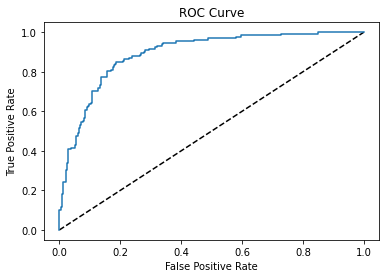

In [45]:
y_pred_prob = final_model.predict_proba(X_test_imp)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve');

print("ROC score: ", roc_auc_score(y_test, y_pred))

**Feature Importance**

In [46]:
feature_importances = pd.DataFrame(final_model.feature_importances_, index = features,\
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                              importance
Glucose                         0.257037
Insulin                         0.210925
Age                             0.172250
SkinThickness                   0.081292
BMI Category_Normal Weight      0.079603
Pregnancies                     0.075036
DiabetesPedigreeFunction        0.052198
BMI Category_Overweight         0.033086
BloodPressure                   0.019341
BMI Category_Class III Obese    0.012013
BMI Category_Class II Obese     0.007181
BMI Category_Underweight        0.000038


As expected, Glucose was the most important feature, followed by Insulin and Age.  

## Output Model

In [47]:
import pickle
modelpath = '../models/final_model.pkl'
with open(modelpath, 'wb') as f:
    pickle.dump(final_model, f)